Target:

Creation of MNIST Basic Neural Network model.

Results:

*   Parameters: 13,160
*   Best Train Accuracy: 99.15%
*   Best Test Accuracy: 98.67%

Analysis:

*   Basic model is overfitted.
*    Let us apply Batch Normalization and Global Averaging Pooling layers to see if the Model performance can be improved.


# Import Libraries

Let's first import all the necessary libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Defining the Model




In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=0,bias=False),  # 28x28 output 28x28 RF : 3x3
            nn.ReLU(),

            nn.Conv2d(8, 16, 3,padding=0,bias=False), # 28x28 output 28x28 RF : 5x5
            nn.ReLU(),

            nn.Conv2d(16, 16, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),
        
        )

        #Transition Block (MaxPool + 1x1)
        self.trans1 = nn.Sequential(

            # 1x1 convolution
            nn.Conv2d(16, 8, 1,bias=False), # 26x26 output - 26x26 RF 14x14
            nn.ReLU(),

            nn.MaxPool2d(2, 2),  # 26x26 output - 13x13 RF 14x14

        )

        #Block 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 16, 3,padding=0, bias=False), # 13x13 output - 11x11 RF 16x16
            nn.ReLU(),

            nn.Conv2d(16, 16, 3,padding=0, bias=False),  # 11x11 output - 9x9 RF 18x18
            nn.ReLU(),

            nn.Conv2d(16, 16, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),

            nn.Conv2d(16, 16, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),

            nn.Conv2d(16, 10, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = x.view(-1,10)

        return F.log_softmax(x,dim=1)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,304
              ReLU-6           [-1, 16, 22, 22]               0
            Conv2d-7            [-1, 8, 22, 22]             128
              ReLU-8            [-1, 8, 22, 22]               0
         MaxPool2d-9            [-1, 8, 11, 11]               0
           Conv2d-10             [-1, 16, 9, 9]           1,152
             ReLU-11             [-1, 16, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           2,304
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [-1, 1

## The Model

In [4]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (trans1): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
)

## Model Parameters

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,160 trainable parameters


## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [6]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Training and Testing Loop

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's write train and test the model

In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1624881476163864 Batch_id=468 Accuracy=44.46: 100%|██████████| 469/469 [00:11<00:00, 42.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2360, Accuracy: 9285/10000 (92.85%)

EPOCH: 1


Loss=0.050729796290397644 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:10<00:00, 42.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0988, Accuracy: 9709/10000 (97.09%)

EPOCH: 2


Loss=0.061119500547647476 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:10<00:00, 43.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9804/10000 (98.04%)

EPOCH: 3


Loss=0.05504143238067627 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:10<00:00, 43.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9825/10000 (98.25%)

EPOCH: 4


Loss=0.02242947183549404 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0614, Accuracy: 9806/10000 (98.06%)

EPOCH: 5


Loss=0.015273728407919407 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9841/10000 (98.41%)

EPOCH: 6


Loss=0.06736594438552856 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 42.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.02484983392059803 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:10<00:00, 43.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9849/10000 (98.49%)

EPOCH: 8


Loss=0.006928298622369766 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9871/10000 (98.71%)

EPOCH: 9


Loss=0.1641177386045456 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:11<00:00, 42.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9867/10000 (98.67%)

EPOCH: 10


Loss=0.04040546342730522 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:10<00:00, 43.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9855/10000 (98.55%)

EPOCH: 11


Loss=0.01782531850039959 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:10<00:00, 42.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9876/10000 (98.76%)

EPOCH: 12


Loss=0.006908572744578123 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 43.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9879/10000 (98.79%)

EPOCH: 13


Loss=0.04312491789460182 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 42.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Loss=0.004439933225512505 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:11<00:00, 42.11it/s]



Test set: Average loss: 0.0424, Accuracy: 9867/10000 (98.67%)



## Observation:





Text(0.5, 1.0, 'Test Accuracy')

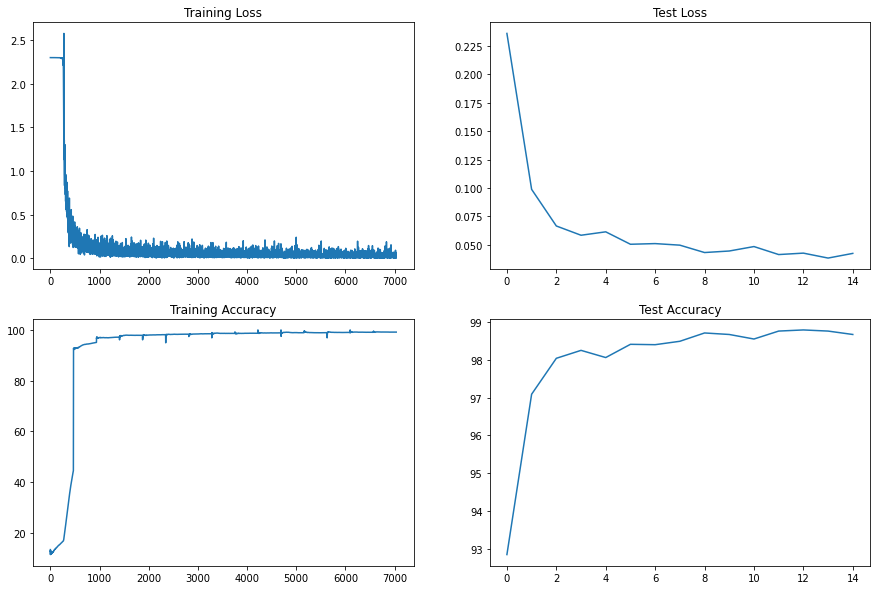

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")